### Notas de aula de Computação Quântica <br> Autor: Jonas Maziero

# Trotterization

In [2]:
import qiskit
from qiskit import *
import math
import numpy as np

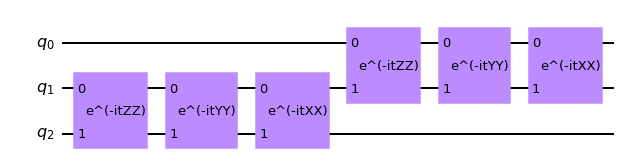

In [3]:
def qc_ezz(t):
    qc = QuantumCircuit(2, name = 'e^(-itZZ)')
    qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1) 
    return qc
def qc_exx(t):
    qc = QuantumCircuit(2, name = 'e^(-itXX)')
    qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1])
    return qc
def qc_eyy(t):
    qc = QuantumCircuit(2, name = 'e^(-itYY)')
    qc.sdg([0,1]); qc.h([0,1]); qc.cx(0, 1); qc.rz(2*t, 1); qc.cx(0, 1); qc.h([0,1]); qc.s([0,1])
    return qc
def qc_Bj(t):
    qc = QuantumCircuit(3, name = 'B_j')
    qc_ezz_ = qc_ezz(t); qc_eyy_ = qc_eyy(t); qc_exx_ = qc_exx(t)
    qc.append(qc_ezz_, [1, 2]); qc.append(qc_eyy_, [1, 2]); qc.append(qc_exx_, [1, 2])
    qc.append(qc_ezz_, [0, 1]); qc.append(qc_eyy_, [0, 1]); qc.append(qc_exx_, [0, 1])
    return qc
qc_Bj_ = qc_Bj(math.pi/2); qc_Bj_.draw(output='mpl')

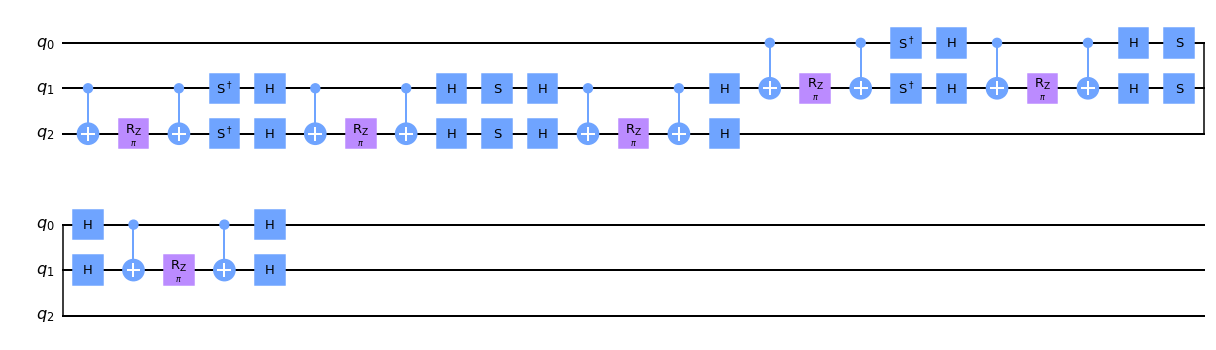

In [4]:
qc_Bj_.decompose().draw(output='mpl')

Each Trotter step is comprised of this circuit. And we need at least 6 Trotter steps to reach the minimum value of state preparation fidelity (theorectically).

In [5]:
nshots = 8192
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_jakarta')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

## With simulated noise

In [6]:
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map

In [8]:
ket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]);
psi0 = np.kron(ket0, np.kron(ket1, ket1)) # initial state to be used for computing the fidelity
t = math.pi
for j in range(0, 10): # Trotter stepsm_info.
    # quantum circuit
    qc = QuantumCircuit(7)
    qc.x([5, 3]) # prepares the initial state
    qc_Bj_ = qc_Bj(t/(j+1))
    for k in range(0, j+1):
        qc.append(qc_Bj_, [5, 3, 1])
    qstc = state_tomography_circuits(qc, [5, 3, 1])
    # simulation
    job_sim = execute(qstc, backend = simulator, shots = nshots)
    qstf_sim = StateTomographyFitter(job_sim.result(), qstc)
    rho_sim = qstf_sim.fit(method = 'lstsq')
    F_sim = quantum_info.state_fidelity(psi0, rho_sim)
    # simulation with simulated noise
    job_exp = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model, 
                      basis_gates = basis_gates, coupling_map = coupling_map)
    qstf_exp = StateTomographyFitter(job_exp.result(), qstc)
    rho_exp = qstf_exp.fit(method = 'lstsq')
    F_exp = quantum_info.state_fidelity(psi0, rho_exp)
    print('No. passos=', j+1, ',F_sim=', F_sim, ',F_exp=', F_exp)

No. passos= 1 ,F_sim= 0.9963522384695273 ,F_exp= 0.8902619858065385
No. passos= 2 ,F_sim= 0.9947608487646025 ,F_exp= 0.730313578759523
No. passos= 3 ,F_sim= 0.07815570017120493 ,F_exp= 0.08717358803081118
No. passos= 4 ,F_sim= 0.0001789585225619678 ,F_exp= 0.043981381846554514
No. passos= 5 ,F_sim= 0.2554298102594595 ,F_exp= 0.17776857241743307
No. passos= 6 ,F_sim= 0.5720959137628336 ,F_exp= 0.2869360828027298
No. passos= 7 ,F_sim= 0.7553962988952234 ,F_exp= 0.32314953969740984
No. passos= 8 ,F_sim= 0.856058137677428 ,F_exp= 0.32258318687283505
No. passos= 9 ,F_sim= 0.9067841142073211 ,F_exp= 0.315328926938061
No. passos= 10 ,F_sim= 0.9391762751736303 ,F_exp= 0.29375866446286564


## With simulated noise and error mitigation

In [6]:
inha visto essa reprovação mas não me dei por conta que n# for error mitigation
qr = QuantumRegister(7)
qubit_list = [5,3,1] # the qubits on which we shall apply error mitigation
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)
job_cal = execute(meas_calibs, backend = simulator, shots = nshots, noise_model = noise_model, 
                  basis_gates = basis_gates, coupling_map = coupling_map)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

In [10]:
ket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]); #ket0, ket1
psi0 = np.kron(ket0, np.kron(ket1, ket1)) # initial state to be used for computing the fidelity
t = math.pi
for j in range(0, 10): # Trotter steps
    # quantum circuit
    qc = QuantumCircuit(7)
    qc.x([5, 3]) # prepares the initial state
    qc_Bj_ = qc_Bj(t/(j+1))
    for k in range(0, j+1):
        qc.append(qc_Bj_, [5, 3, 1])
    qstc = state_tomography_circuits(qc, [5, 3, 1])
    # simulation
    job_sim = execute(qstc, backend = simulator, shots = nshots)
    qstf_sim = StateTomographyFitter(job_sim.result(), qstc)
    rho_sim = qstf_sim.fit(method = 'lstsq')
    F_sim = quantum_info.state_fidelity(psi0, rho_sim)
    # simulation with simulated noise and error mitigation
    job_exp = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model, 
                      basis_gates = basis_gates, coupling_map = coupling_map)
    mitigated_results = meas_fitter.filter.apply(job_exp.result())
    qstf_exp = StateTomographyFitter(mitigated_results, qstc)
    rho_exp = qstf_exp.fit(method = 'lstsq')
    F_exp = quantum_info.state_fidelity(psi0, rho_exp)
    print('No. passos=', j+1, ',F_sim=', F_sim, ',F_exp=', F_exp)

No. passos= 1 ,F_sim= 0.993584062782807 ,F_exp= 0.9944334009373328
No. passos= 2 ,F_sim= 0.9961568945773354 ,F_exp= 0.8210299511515393
No. passos= 3 ,F_sim= 0.07741402901794962 ,F_exp= 0.09105479051651923
No. passos= 4 ,F_sim= 0.000294433386341252 ,F_exp= 0.03959667142545146
No. passos= 5 ,F_sim= 0.2558980804126396 ,F_exp= 0.18750282857972903
No. passos= 6 ,F_sim= 0.5701045548852492 ,F_exp= 0.31198753510033883
No. passos= 7 ,F_sim= 0.7557034446187959 ,F_exp= 0.35477312578509096
No. passos= 8 ,F_sim= 0.8534659455932252 ,F_exp= 0.3660980569379751
No. passos= 9 ,F_sim= 0.9079181429886654 ,F_exp= 0.3427865351410006
No. passos= 10 ,F_sim= 0.9395362544254358 ,F_exp= 0.3187275247855099


We see that, in this case, the application of error mitigation is of little help, since it improves only a little bit the results.

# With simulated noise, error mitigation, and symmetry transformations

## Z&Z
$B_{j} = \Big(e^{iZ\phi}\otimes e^{iZ\phi}\otimes I\Big)\Big(e^{-iH_{xxx}^{(2)}t/j}\otimes I\Big)\Big(e^{-iZ\phi}\otimes e^{-iZ\phi}\otimes I\Big)\Big(I\otimes e^{iZ\theta}\otimes e^{iZ\theta}\Big)\Big(I\otimes e^{-iH_{xxx}^{(2)}t/j}\Big)\Big(I\otimes e^{-iZ\theta}\otimes e^{-iZ\theta}\Big)$

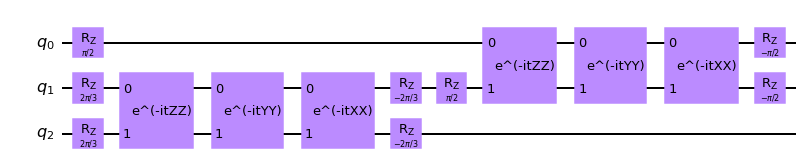

In [12]:
def qc_Bj_zz(t, th, ph):
    qc = QuantumCircuit(3, name = 'B_j_zz')
    qc_ezz_ = qc_ezz(t); qc_eyy_ = qc_eyy(t); qc_exx_ = qc_exx(t)
    qc.rz(2*th, [1,2])
    qc.append(qc_ezz_, [1, 2]); qc.append(qc_eyy_, [1, 2]); qc.append(qc_exx_, [1, 2])
    qc.rz(-2*th, [1,2])
    qc.rz(2*ph, [0,1])
    qc.append(qc_ezz_, [0, 1]); qc.append(qc_eyy_, [0, 1]); qc.append(qc_exx_, [0, 1])
    qc.rz(-2*ph, [0,1])
    return qc
qc_Bj_zz_ = qc_Bj_zz(math.pi, math.pi/3, math.pi/4); qc_Bj_zz_.draw(output='mpl')

In [14]:
ket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]); #ket0, ket1
psi0 = np.kron(ket0, np.kron(ket1, ket1)) # initial state to be used for computing the fidelity
t = math.pi
j = 6; print('N. of Trotter steps = ', j+1)
th_max = 2*math.pi; dth = th_max/16; th = np.arange(0, th_max+dth, dth); dim_th = th.shape[0] 
ph_max = 2*math.pi; dph = ph_max/16; ph = np.arange(0, ph_max+dph, dph); dim_ph = ph.shape[0]
for m in range(0, dim_th):
    for n in range(0, dim_ph):
        # quantum circuit
        qc = QuantumCircuit(7)
        qc.x([5, 3]) # prepares the initial state
        qc_Bj_zz_ = qc_Bj_zz(t/(j+1), th[m], ph[n])
        for k in range(0, j+1):
            qc.append(qc_Bj_zz_, [5, 3, 1])
        qstc = state_tomography_circuits(qc, [5, 3, 1])
        # simulation
        job_sim = execute(qstc, backend = simulator, shots = nshots)
        qstf_sim = StateTomographyFitter(job_sim.result(), qstc)
        rho_sim = qstf_sim.fit(method = 'lstsq')
        F_sim = quantum_info.state_fidelity(psi0, rho_sim)
        # simulation with simulated noise and error mitigation
        job_exp = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model, 
                          basis_gates = basis_gates, coupling_map = coupling_map)
        mitigated_results = meas_fitter.filter.apply(job_exp.result())
        qstf_exp = StateTomographyFitter(mitigated_results, qstc)
        rho_exp = qstf_exp.fit(method = 'lstsq')
        F_exp = quantum_info.state_fidelity(psi0, rho_exp)
        print('th=', th[m], ', ph=', ph[n], ', F_sim=', F_sim, ', F_exp=', F_exp)

N. of Trotter steps =  7
th= 0.0 , ph= 0.0 , F_sim= 0.7514835706221239 , F_exp= 0.3435370505598307
th= 0.0 , ph= 0.39269908169872414 , F_sim= 0.7545022020009995 , F_exp= 0.3443415318767427
th= 0.0 , ph= 0.7853981633974483 , F_sim= 0.7578986664148561 , F_exp= 0.3350677192590238
th= 0.0 , ph= 1.1780972450961724 , F_sim= 0.7555241279536397 , F_exp= 0.3392380045346095
th= 0.0 , ph= 1.5707963267948966 , F_sim= 0.7543073708811642 , F_exp= 0.3447348689842848
th= 0.0 , ph= 1.9634954084936207 , F_sim= 0.7554170130590101 , F_exp= 0.3364980821998658
th= 0.0 , ph= 2.356194490192345 , F_sim= 0.7562060159840175 , F_exp= 0.3464377436226702
th= 0.0 , ph= 2.748893571891069 , F_sim= 0.7564398363724276 , F_exp= 0.3402048031106723
th= 0.0 , ph= 3.141592653589793 , F_sim= 0.7557178274572267 , F_exp= 0.3438452652457532
th= 0.0 , ph= 3.5342917352885173 , F_sim= 0.7585508368709359 , F_exp= 0.34616212200407875
th= 0.0 , ph= 3.9269908169872414 , F_sim= 0.7544645392479595 , F_exp= 0.3428744123761173
th= 0.0 , ph

th= 1.5707963267948966 , ph= 5.497787143782138 , F_sim= 0.7550470047543355 , F_exp= 0.3418225058420374
th= 1.5707963267948966 , ph= 5.890486225480862 , F_sim= 0.7534449340599126 , F_exp= 0.3408998025021335
th= 1.5707963267948966 , ph= 6.283185307179586 , F_sim= 0.7549828279313999 , F_exp= 0.3383661369314889
th= 1.9634954084936207 , ph= 0.0 , F_sim= 0.7564985738875545 , F_exp= 0.34505076816555097
th= 1.9634954084936207 , ph= 0.39269908169872414 , F_sim= 0.7575718740503073 , F_exp= 0.33578417363135593
th= 1.9634954084936207 , ph= 0.7853981633974483 , F_sim= 0.7561000095258942 , F_exp= 0.34233291183119624
th= 1.9634954084936207 , ph= 1.1780972450961724 , F_sim= 0.753709170425954 , F_exp= 0.33511613335169665
th= 1.9634954084936207 , ph= 1.5707963267948966 , F_sim= 0.7559503364409168 , F_exp= 0.3437297988336596
th= 1.9634954084936207 , ph= 1.9634954084936207 , F_sim= 0.7558818976320041 , F_exp= 0.340748211913689
th= 1.9634954084936207 , ph= 2.356194490192345 , F_sim= 0.7568642702146849 , F_

th= 3.5342917352885173 , ph= 3.9269908169872414 , F_sim= 0.7576302695558798 , F_exp= 0.33690635015207904
th= 3.5342917352885173 , ph= 4.319689898685965 , F_sim= 0.7536009504249792 , F_exp= 0.3434345245861281
th= 3.5342917352885173 , ph= 4.71238898038469 , F_sim= 0.756945418726719 , F_exp= 0.34099967927047353
th= 3.5342917352885173 , ph= 5.105088062083414 , F_sim= 0.7562584658047072 , F_exp= 0.3388402584500343
th= 3.5342917352885173 , ph= 5.497787143782138 , F_sim= 0.7569574200119902 , F_exp= 0.34157290573428273
th= 3.5342917352885173 , ph= 5.890486225480862 , F_sim= 0.7549128544199277 , F_exp= 0.34374589036689407
th= 3.5342917352885173 , ph= 6.283185307179586 , F_sim= 0.7524048663089675 , F_exp= 0.3452301540327327
th= 3.9269908169872414 , ph= 0.0 , F_sim= 0.7520155461663359 , F_exp= 0.34222530227630293
th= 3.9269908169872414 , ph= 0.39269908169872414 , F_sim= 0.7557005744698977 , F_exp= 0.3327475033535287
th= 3.9269908169872414 , ph= 0.7853981633974483 , F_sim= 0.7546755234350987 , F_e

KeyboardInterrupt: 

## Z&X
$B_{j} = \Big(e^{iZ\phi}\otimes e^{iZ\phi}\otimes I\Big)\Big(e^{-iH_{xxx}^{(2)}t/j}\otimes I\Big)\Big(e^{-iZ\phi}\otimes e^{-iZ\phi}\otimes I\Big)\Big(I\otimes e^{iX\theta}\otimes e^{iX\theta}\Big)\Big(I\otimes e^{-iH_{xxx}^{(2)}t/j}\Big)\Big(I\otimes e^{-iX\theta}\otimes e^{-iX\theta}\Big)$

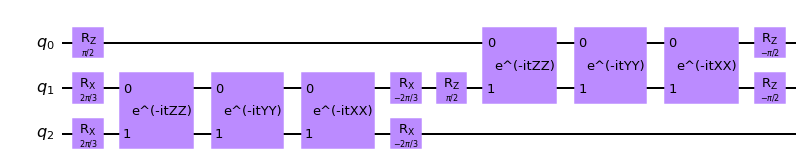

In [15]:
def qc_Bj_zx(t, th, ph):
    qc = QuantumCircuit(3, name = 'B_j_zz')
    qc_ezz_ = qc_ezz(t); qc_eyy_ = qc_eyy(t); qc_exx_ = qc_exx(t)
    qc.rx(2*th, [1,2])
    qc.append(qc_ezz_, [1, 2]); qc.append(qc_eyy_, [1, 2]); qc.append(qc_exx_, [1, 2])
    qc.rx(-2*th, [1,2])
    qc.rz(2*ph, [0,1])
    qc.append(qc_ezz_, [0, 1]); qc.append(qc_eyy_, [0, 1]); qc.append(qc_exx_, [0, 1])
    qc.rz(-2*ph, [0,1])
    return qc
qc_Bj_zx_ = qc_Bj_zx(math.pi, math.pi/3, math.pi/4); qc_Bj_zx_.draw(output='mpl')

In [16]:
inha visto essa reprovação mas não me dei por conta que nket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]); #ket0, ket1
psi0 = np.kron(ket0, np.kron(ket1, ket1)) # initial state to be used for computing the fidelity
t = math.pi
j = 6; print('N. of Trotter steps = ', j+1)
th_max = 2*math.pi; dth = th_max/16; th = np.arange(0, th_max+dth, dth); dim_th = th.shape[0] 
ph_max = 2*math.pi; dph = ph_max/16; ph = np.arange(0, ph_max+dph, dph); dim_ph = ph.shape[0]
for m in range(0, dim_th):
    for n in range(0, dim_ph):
        # quantum circuit
        qc = QuantumCircuit(7)
        qc.x([5, 3]) # prepares the initial state
        qc_Bj_zx_ = qc_Bj_zx(t/(j+1), th[m], ph[n])
        for k in range(0, j+1):
            qc.append(qc_Bj_zx_, [5, 3, 1])
        qstc = state_tomography_circuits(qc, [5, 3, 1])
        # simulation
        job_sim = execute(qstc, backend = simulator, shots = nshots)
        qstf_sim = StateTomographyFitter(job_sim.result(), qstc)
        rho_sim = qstf_sim.fit(method = 'lstsq')
        F_sim = quantum_info.state_fidelity(psi0, rho_sim)
        # simulation with simulated noise and error mitigation
        job_exp = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model, 
                          basis_gates = basis_gates, coupling_map = coupling_map)
        mitigated_results = meas_fitter.filter.apply(job_exp.result())
        qstf_exp = StateTomographyFitter(mitigated_results, qstc)
        rho_exp = qstf_exp.fit(method = 'lstsq')
        F_exp = quantum_info.state_fidelity(psi0, rho_exp)
        print('th=', th[m], ', ph=', ph[n], ', F_sim=', F_sim, ', F_exp=', F_exp)

N. of Trotter steps =  7
th= 0.0 , ph= 0.0 , F_sim= 0.7566309257801583 , F_exp= 0.3395965436026181
th= 0.0 , ph= 0.39269908169872414 , F_sim= 0.7563432910252593 , F_exp= 0.34069021246443715
th= 0.0 , ph= 0.7853981633974483 , F_sim= 0.7560938156565578 , F_exp= 0.33993036402923443
th= 0.0 , ph= 1.1780972450961724 , F_sim= 0.7568810968187896 , F_exp= 0.3334485346564917
th= 0.0 , ph= 1.5707963267948966 , F_sim= 0.7575148465853553 , F_exp= 0.3344462741363273
th= 0.0 , ph= 1.9634954084936207 , F_sim= 0.7570646634633789 , F_exp= 0.3398437200888355
th= 0.0 , ph= 2.356194490192345 , F_sim= 0.7581406590644275 , F_exp= 0.33882310449819614
th= 0.0 , ph= 2.748893571891069 , F_sim= 0.7561094154852785 , F_exp= 0.33700209134728354
th= 0.0 , ph= 3.141592653589793 , F_sim= 0.7553892545407266 , F_exp= 0.3403178787391218
th= 0.0 , ph= 3.5342917352885173 , F_sim= 0.7577741751868666 , F_exp= 0.33593389007306557
th= 0.0 , ph= 3.9269908169872414 , F_sim= 0.7550821032676801 , F_exp= 0.3395583644285119
th= 0.0 

th= 1.5707963267948966 , ph= 5.497787143782138 , F_sim= 0.7565148676940875 , F_exp= 0.34533848111958
th= 1.5707963267948966 , ph= 5.890486225480862 , F_sim= 0.755184980822099 , F_exp= 0.34912269793975786
th= 1.5707963267948966 , ph= 6.283185307179586 , F_sim= 0.7570095316646209 , F_exp= 0.3486085316592514
th= 1.9634954084936207 , ph= 0.0 , F_sim= 0.7577359646298092 , F_exp= 0.3383489786959866
th= 1.9634954084936207 , ph= 0.39269908169872414 , F_sim= 0.7548559752253705 , F_exp= 0.3332336886162436
th= 1.9634954084936207 , ph= 0.7853981633974483 , F_sim= 0.7572767655627233 , F_exp= 0.33712388058932996
th= 1.9634954084936207 , ph= 1.1780972450961724 , F_sim= 0.7583061845379327 , F_exp= 0.34011277989958505
th= 1.9634954084936207 , ph= 1.5707963267948966 , F_sim= 0.7560517566903999 , F_exp= 0.33100214120310356
th= 1.9634954084936207 , ph= 1.9634954084936207 , F_sim= 0.7572455450602381 , F_exp= 0.33337219136674756
th= 1.9634954084936207 , ph= 2.356194490192345 , F_sim= 0.756318133853299 , F_e

th= 3.5342917352885173 , ph= 3.9269908169872414 , F_sim= 0.7563291859659125 , F_exp= 0.3268368231371777
th= 3.5342917352885173 , ph= 4.319689898685965 , F_sim= 0.7530641575934186 , F_exp= 0.333555150917086
th= 3.5342917352885173 , ph= 4.71238898038469 , F_sim= 0.7561034744153116 , F_exp= 0.3362440650239052
th= 3.5342917352885173 , ph= 5.105088062083414 , F_sim= 0.75657597967663 , F_exp= 0.33473825910408195
th= 3.5342917352885173 , ph= 5.497787143782138 , F_sim= 0.7551117582176344 , F_exp= 0.33805281363682643
th= 3.5342917352885173 , ph= 5.890486225480862 , F_sim= 0.7554916068879923 , F_exp= 0.331525153367286
th= 3.5342917352885173 , ph= 6.283185307179586 , F_sim= 0.7554336994758555 , F_exp= 0.3441031909615115
th= 3.9269908169872414 , ph= 0.0 , F_sim= 0.7581424106628049 , F_exp= 0.34349150050434324
th= 3.9269908169872414 , ph= 0.39269908169872414 , F_sim= 0.7557276630444897 , F_exp= 0.34727177348109606
th= 3.9269908169872414 , ph= 0.7853981633974483 , F_sim= 0.7534345566218174 , F_exp= 

th= 5.497787143782138 , ph= 2.356194490192345 , F_sim= 0.7544018494899077 , F_exp= 0.3338939697020102
th= 5.497787143782138 , ph= 2.748893571891069 , F_sim= 0.7557455513880513 , F_exp= 0.33681747351311264
th= 5.497787143782138 , ph= 3.141592653589793 , F_sim= 0.7560046041063049 , F_exp= 0.33759236738475723
th= 5.497787143782138 , ph= 3.5342917352885173 , F_sim= 0.7548993243122994 , F_exp= 0.3369366828240827
th= 5.497787143782138 , ph= 3.9269908169872414 , F_sim= 0.7564193344442381 , F_exp= 0.3337013569545478
th= 5.497787143782138 , ph= 4.319689898685965 , F_sim= 0.7544675176134329 , F_exp= 0.3293249929157355
th= 5.497787143782138 , ph= 4.71238898038469 , F_sim= 0.7564602922361788 , F_exp= 0.3399600333665414
th= 5.497787143782138 , ph= 5.105088062083414 , F_sim= 0.7553194387556592 , F_exp= 0.33967912746161916
th= 5.497787143782138 , ph= 5.497787143782138 , F_sim= 0.754464045087035 , F_exp= 0.3354316194161347
th= 5.497787143782138 , ph= 5.890486225480862 , F_sim= 0.7549967538982861 , F_e

## Y&X
$B_{j} = \Big(e^{iY\phi}\otimes e^{iY\phi}\otimes I\Big)\Big(e^{-iH_{xxx}^{(2)}t/j}\otimes I\Big)\Big(e^{-iY\phi}\otimes e^{-iY\phi}\otimes I\Big)\Big(I\otimes e^{iX\theta}\otimes e^{iX\theta}\Big)\Big(I\otimes e^{-iH_{xxx}^{(2)}t/j}\Big)\Big(I\otimes e^{-iX\theta}\otimes e^{-iX\theta}\Big)$

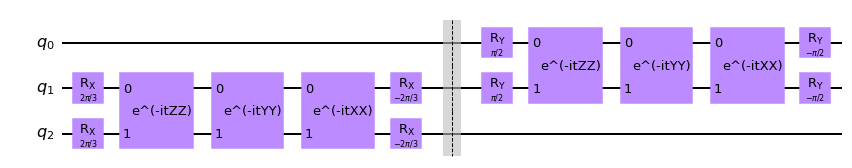

In [18]:
def qc_Bj_yx(t, th, ph):
    qc = QuantumCircuit(3, name = 'B_j_zz')
    qc_ezz_ = qc_ezz(t); qc_eyy_ = qc_eyy(t); qc_exx_ = qc_exx(t)
    qc.rx(2*th, [1,2])
    qc.append(qc_ezz_, [1, 2]); qc.append(qc_eyy_, [1, 2]); qc.append(qc_exx_, [1, 2])
    qc.rx(-2*th, [1,2])
    qc.barrier()
    qc.ry(2*ph, [0,1])
    qc.append(qc_ezz_, [0, 1]); qc.append(qc_eyy_, [0, 1]); qc.append(qc_exx_, [0, 1])
    qc.ry(-2*ph, [0,1])
    return qc
qc_Bj_yx_ = qc_Bj_yx(math.pi, math.pi/3, math.pi/4); qc_Bj_yx_.draw(output='mpl')

In [19]:
https://arxiv.org/abs/2204.07816ket0 = np.array([[1],[0]]); ket1 = np.array([[0],[1]]); #ket0, ket1
psi0 = np.kron(ket0, np.kron(ket1, ket1)) # initial state to be used for computing the fidelity
t = math.pi
j = 6; print('N. of Trotter steps = ', j+1)
th_max = 2*math.pi; dth = th_max/16; th = np.arange(0, th_max+dth, dth); dim_th = th.shape[0] 
ph_max = 2*math.pi; dph = ph_max/16; ph = np.arange(0, ph_max+dph, dph); dim_ph = ph.shape[0]
for m in range(0, dim_th):
    for n in range(0, dim_ph):
        # quantum circuit
        qc = QuantumCircuit(7)
        qc.x([5, 3]) # prepares the initial state
        qc_Bj_yx_ = qc_Bj_yx(t/(j+1), th[m], ph[n])
        for k in range(0, j+1):
            qc.append(qc_Bj_yx_, [5, 3, 1])
        qstc = state_tomography_circuits(qc, [5, 3, 1])
        # simulation
        job_sim = execute(qstc, backend = simulator, shots = nshots)
        qstf_sim = StateTomographyFitter(job_sim.result(), qstc)
        rho_sim = qstf_sim.fit(method = 'lstsq')
        F_sim = quantum_info.state_fidelity(psi0, rho_sim)
        # simulation with simulated noise and error mitigation0.34
        job_exp = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model, 
                          basis_gates = basis_gates, coupling_map = coupling_map)
        mitigated_results = meas_fitter.filter.apply(job_exp.result())
        qstf_exp = StateTomographyFitter(mitigated_results, qstc)
        rho_exp = qstf_exp.fit(method = 'lstsq')
        F_exp = quantum_info.state_fidelity(psi0, rho_exp)
        print('th=', th[m], ', ph=', ph[n], ', F_sim=', F_sim, ', F_exp=', F_exp)

N. of Trotter steps =  7
th= 0.0 , ph= 0.0 , F_sim= 0.7551137694530948 , F_exp= 0.3354730762525695
th= 0.0 , ph= 0.39269908169872414 , F_sim= 0.7551981855450024 , F_exp= 0.335586819204906
th= 0.0 , ph= 0.7853981633974483 , F_sim= 0.7541769003824066 , F_exp= 0.3403493531904914
th= 0.0 , ph= 1.1780972450961724 , F_sim= 0.7553571943813538 , F_exp= 0.3395038603564707
th= 0.0 , ph= 1.5707963267948966 , F_sim= 0.7565000707885268 , F_exp= 0.34590327091149353
th= 0.0 , ph= 1.9634954084936207 , F_sim= 0.7569374264384373 , F_exp= 0.341512589169562
th= 0.0 , ph= 2.356194490192345 , F_sim= 0.7550490401312734 , F_exp= 0.3442954294363231
th= 0.0 , ph= 2.748893571891069 , F_sim= 0.7555054612888856 , F_exp= 0.3420332731900966
th= 0.0 , ph= 3.141592653589793 , F_sim= 0.7568576464238922 , F_exp= 0.3371829299581219
th= 0.0 , ph= 3.5342917352885173 , F_sim= 0.7551014687246482 , F_exp= 0.3383990663487816
th= 0.0 , ph= 3.9269908169872414 , F_sim= 0.7539208565585682 , F_exp= 0.34077115504775135
th= 0.0 , ph=

th= 1.5707963267948966 , ph= 5.497787143782138 , F_sim= 0.7550621198013833 , F_exp= 0.34584503742027756
th= 1.5707963267948966 , ph= 5.890486225480862 , F_sim= 0.7547058495779438 , F_exp= 0.34155218953080496
th= 1.5707963267948966 , ph= 6.283185307179586 , F_sim= 0.7559365878825864 , F_exp= 0.3456818408188763
th= 1.9634954084936207 , ph= 0.0 , F_sim= 0.7565242486519675 , F_exp= 0.3241037584356474
th= 1.9634954084936207 , ph= 0.39269908169872414 , F_sim= 0.7557604455585107 , F_exp= 0.32178941676763
th= 1.9634954084936207 , ph= 0.7853981633974483 , F_sim= 0.754231539367493 , F_exp= 0.3294921210213512
th= 1.9634954084936207 , ph= 1.1780972450961724 , F_sim= 0.7547484739219945 , F_exp= 0.3274042029464227
th= 1.9634954084936207 , ph= 1.5707963267948966 , F_sim= 0.7534015155213951 , F_exp= 0.33403299931260666
th= 1.9634954084936207 , ph= 1.9634954084936207 , F_sim= 0.7555702162642968 , F_exp= 0.32440925584058183
th= 1.9634954084936207 , ph= 2.356194490192345 , F_sim= 0.7572563239368686 , F_e

th= 3.5342917352885173 , ph= 3.9269908169872414 , F_sim= 0.7531945847437758 , F_exp= 0.3289898299636614
th= 3.5342917352885173 , ph= 4.319689898685965 , F_sim= 0.7543636425418033 , F_exp= 0.3260785963951726
th= 3.5342917352885173 , ph= 4.71238898038469 , F_sim= 0.755219220177104 , F_exp= 0.3314689225724116
th= 3.5342917352885173 , ph= 5.105088062083414 , F_sim= 0.7553183713135232 , F_exp= 0.32200160516895604
th= 3.5342917352885173 , ph= 5.497787143782138 , F_sim= 0.7558297542393516 , F_exp= 0.3316106458985437
th= 3.5342917352885173 , ph= 5.890486225480862 , F_sim= 0.7548797582754211 , F_exp= 0.3270368328002281
th= 3.5342917352885173 , ph= 6.283185307179586 , F_sim= 0.7558921584758238 , F_exp= 0.32614491820316976
th= 3.9269908169872414 , ph= 0.0 , F_sim= 0.7556061877202795 , F_exp= 0.3387302354096385
th= 3.9269908169872414 , ph= 0.39269908169872414 , F_sim= 0.7556128502052387 , F_exp= 0.3325926318254865
th= 3.9269908169872414 , ph= 0.7853981633974483 , F_sim= 0.7568383407586469 , F_exp=

th= 5.497787143782138 , ph= 2.356194490192345 , F_sim= 0.7546573956962407 , F_exp= 0.3375105923509854
th= 5.497787143782138 , ph= 2.748893571891069 , F_sim= 0.7545129299695115 , F_exp= 0.3300334156102854
th= 5.497787143782138 , ph= 3.141592653589793 , F_sim= 0.7541728135748124 , F_exp= 0.33626335630503684
th= 5.497787143782138 , ph= 3.5342917352885173 , F_sim= 0.756789812748325 , F_exp= 0.32618102785805964
th= 5.497787143782138 , ph= 3.9269908169872414 , F_sim= 0.7546083344625502 , F_exp= 0.3328897557098014
th= 5.497787143782138 , ph= 4.319689898685965 , F_sim= 0.7561833149831059 , F_exp= 0.33486922723969603
th= 5.497787143782138 , ph= 4.71238898038469 , F_sim= 0.7551382050872206 , F_exp= 0.33529959843218016
th= 5.497787143782138 , ph= 5.105088062083414 , F_sim= 0.7547948944658194 , F_exp= 0.33488835990536714
th= 5.497787143782138 , ph= 5.497787143782138 , F_sim= 0.7542592608742346 , F_exp= 0.337206833999476
th= 5.497787143782138 , ph= 5.890486225480862 , F_sim= 0.7570233119060236 , F_

# Soluções
Das soluções que consegui ler, lembro de algumas que são ideias bem simples. Uma delas é encontrar uma maneira mais econômica de implementar 
\begin{equation}
e^{-iH_{xxx}^{(jk)}t}=e^{-iZZt}e^{-iYYt}e^{-iXXt}.
\end{equation}
Para isso, precisamos saber quais são as portas básicas, ou seja, o conjunto base de portas em termos das quais todas as outras são implementadas.

In [8]:
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map

In [9]:
basis_gates

['cx', 'id', 'reset', 'rz', 'sx', 'x']

In [11]:
print(coupling_map)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]]


# Correção de erros de portas?

In [4]:
553/3

184.33333333333334